In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 60.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import math

import humanize
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def generate_legendre_dataset(n=10, max_degree=10, coeff_bounds=(-5, 5), domain_bounds=(-1, 1), domain_size=100) -> np.ndarray:
    domain = np.linspace(*domain_bounds, domain_size)
    coeffs = np.random.randint(*coeff_bounds, size=(n, max_degree))
    dataset = np.zeros((n, domain_size))
    for i in range(n):
        dataset[i, :] = np.polynomial.legendre.Legendre(list(coeffs[i, :]))(domain)
    return dataset

dataset = generate_legendre_dataset(n=10_000)
dataset.shape

(10000, 100)

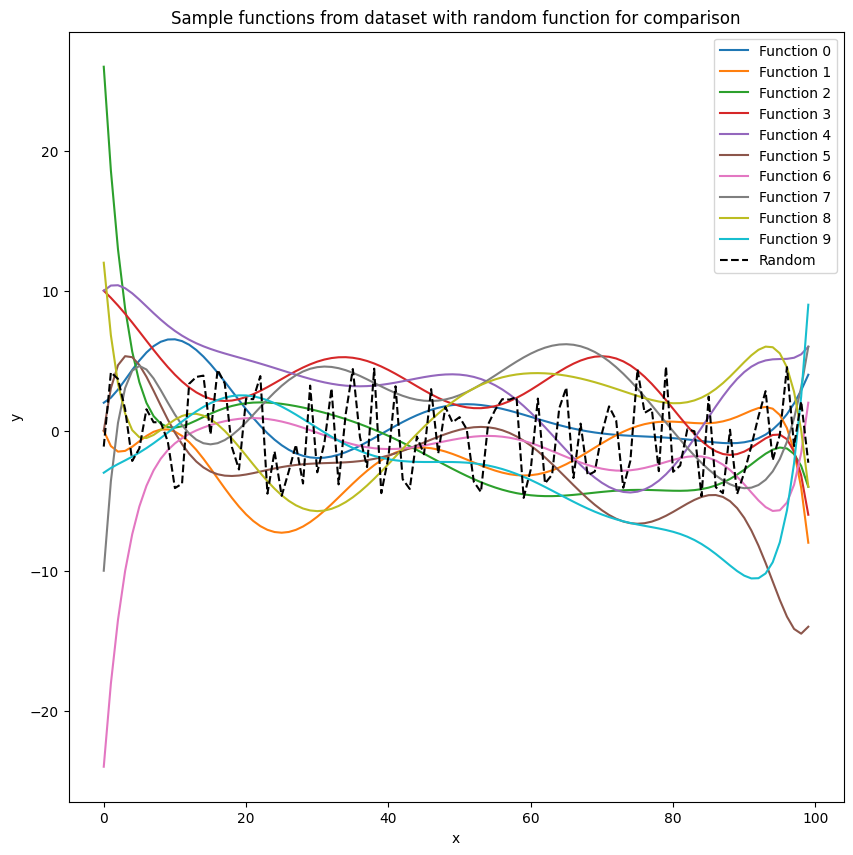

In [4]:
# Plot the first 10 functions
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.plot(dataset[i, :], label=f'Function {i}')
plt.plot(np.random.uniform(-5, 5, 100), label='Random', linestyle='--', color='black')
plt.legend()
plt.title("Sample functions from dataset with random function for comparison")
plt.ylabel("y")
plt.xlabel("x")
plt.show()

In [5]:
class LegendreDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(x, dtype=torch.float32)
    
# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Create Dataset instances
train_dataset = LegendreDataset(train_data)
val_dataset = LegendreDataset(val_data)
test_dataset = LegendreDataset(test_data)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
# Sample batch size
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 100]), torch.Size([64, 100]))

Useful paper: [Annotated Diffusion](https://huggingface.co/blog/annotated-diffusion)
Original paper: [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)

Rescale the data to 0-1 by standardizing. This makes adding noise simpler and also makes the model more robust to the scale of the input data.

Basic architecture blocks (in the original paper):
- UNet with Wide Resnet blocks for the diffusion process
- Sinusoidal positional embeddings for encoding the t step noise level
- Both multiheaded attention and linear attention layers between residual blocks
- GroupNorm for normalization (paper: https://arxiv.org/pdf/1803.08494.pdf)

Sequence of blocks:
1. Convolutional layer applied to batch of noisy images with computed position embeddings for the noise levels
2. Downsampling blocks: 2 ResNet blocks + group norm + attention + residual connection + downsampling
3. Middle of the network: Resnet blocks interweaved with attention layers
4. Upsaampling blocks: 2 ResNet blocks + group norm + attention + residual connection + upsampling
5. Final ResNet block + convolutional layer

Proposed architecture for 1D DDPM:
- Linear autoencoder with residual connections instead of UNet
- Sinusoidal positional embeddings for encoding the t step noise level
- Multiheaded attention layers applied at the middle of the network
- 1D batchnorm instead of groupnorm - groupnorm is effectively channel-wise batchnorm


In [64]:
class LinearBlock(nn.Module):
    def __init__(self, in_features: int, out_features: int, num_heads: int, activation: nn.Module):
        super().__init__()
        self.linear1 = nn.Linear(in_features, in_features)
        self.activation = activation
        self.batch_norm = nn.BatchNorm2d(1)
        self.multihead_attention = nn.MultiheadAttention(in_features * 2, num_heads)  # Update this line
        self.linear2 = nn.Linear(in_features * 2, out_features)  # Update this line


    def forward(self, x):
        x = x.unsqueeze(1)  # Add dummy sequence length dimension
        x = self.activation(self.linear1(x))
        x = self.activation(x)
        x = x.unsqueeze(1)  # Add channel dimension
        x = x.view(x.size(0), 1, x.size(2), -1)  # Reshape for batch normalization
        x = self.batch_norm(x)
        x = x.view(x.size(0), x.size(2), -1)  # Reshape back to original dimensions
        x = x.squeeze(1)  # Remove dummy sequence length dimension
        x = x.transpose(0, 1)  # Rearrange dimensions for multihead attention
        attn_output, _ = self.multihead_attention(x, x, x)
        x = attn_output.transpose(0, 1)  # Rearrange dimensions back
        x = self.linear2(x)
        x = self.activation(x)
        return x



class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        batch_size, seq_len, _ = time.size()
        device = time.device
        half_dim = self.dim // 2
        div_term = math.log(10000) / (half_dim - 1)
        div_term = torch.exp(torch.arange(0, half_dim, device=device) * -div_term)
        
        pos = torch.arange(0, seq_len, device=device).float()
        pos = pos.unsqueeze(0).repeat(batch_size, 1).unsqueeze(-1)
        embeddings = pos * div_term.unsqueeze(0).unsqueeze(1)
        
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings.unsqueeze(1)  # Add dummy sequence length dimension




class LinearUNet(nn.Module):
    def __init__(self, input_dim: int, num_heads: int, activation: nn.Module):
        super().__init__()
        self.encoder1 = LinearBlock(input_dim, 256, num_heads, activation)
        self.encoder2 = LinearBlock(256, 128, num_heads, activation)
        self.encoder3 = LinearBlock(128, 64, num_heads, activation)
        self.encoder4 = LinearBlock(64, 32, num_heads, activation)
        self.latent = nn.Sequential(
            LinearBlock(32, 32, num_heads, activation),
            LinearBlock(32, 32, num_heads, activation),
        )
        self.decoder1 = LinearBlock(32, 64, num_heads, activation)
        self.decoder2 = LinearBlock(64, 128, num_heads, activation)
        self.decoder3 = LinearBlock(128, 256, num_heads, activation)
        self.decoder4 = LinearBlock(256, input_dim, num_heads, activation)

    def forward(self, x):
        x = x.unsqueeze(2)  # Add channel dimension
        e1 = self.encoder1(x.transpose(0, 1))
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        l = self.latent(e4)
        # Skip connections
        x = l + e4
        x = self.decoder1(x)
        x += e3
        x = self.decoder2(x)
        x += e2
        x = self.decoder3(x)
        x += e1
        x = self.decoder4(x)
        return x.squeeze(2)  # Remove the channel dimension

sample_linear_unet = LinearUNet(100, 2, nn.ReLU())
print(sample_linear_unet)

LinearUNet(
  (encoder1): LinearBlock(
    (linear1): Linear(in_features=100, out_features=100, bias=True)
    (activation): ReLU()
    (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (multihead_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
    )
    (linear2): Linear(in_features=200, out_features=256, bias=True)
  )
  (encoder2): LinearBlock(
    (linear1): Linear(in_features=256, out_features=256, bias=True)
    (activation): ReLU()
    (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (multihead_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear2): Linear(in_features=512, out_features=128, bias=True)
  )
  (encoder3): LinearBlock(
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (activation):

In [65]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
param_count = count_parameters(sample_linear_unet)
print(f"Total number of trainable parameters: {humanize.intcomma(param_count)}")

Total number of trainable parameters: 3,436,236


In [66]:
# GPT suggested training code
import torch.optim as optim

# Hyperparameters
num_epochs = 10
learning_rate = 1e-3

# Create the model
input_dim = 100
num_heads = 4
activation = nn.ReLU()

model = LinearUNet(input_dim, num_heads, activation)
model = model.to(device)

# Create the position embeddings
pos_embedding = SinusoidalPositionEmbeddings(input_dim)
pos_embedding = pos_embedding.to(device)

# Noise schedule
num_timesteps = 1000
noise_schedule = torch.linspace(1.0, 0.0, num_timesteps).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        # Apply position embeddings
        inputs = inputs + pos_embedding(inputs.unsqueeze(1))

        # Add noise to inputs according to the noise schedule
        noise_level = noise_schedule[epoch % num_timesteps]
        noisy_inputs = inputs + torch.randn_like(inputs) * noise_level

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(noisy_inputs)

        # Loss calculation and backpropagation
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print training loss for this epoch
    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss}")

    # Validate the model
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = pos_embedding(inputs)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}")

    # save the model
    torch.save(model.state_dict(), f"model_{epoch}.pth")


AssertionError: was expecting embedding dimension of 200, but got 1

In [ ]:
# See how well the model denoises a random Legendre function

# Generate a random Legendre function
coeffs = np.random.randint(-5, 5, size=10)
domain = np.linspace(-1, 1, 100)
legendre_func = np.polynomial.legendre.Legendre(coeffs)(domain)

# Add noise to the function
noise_std = 0.1
noisy_legendre = legendre_func + np.random.normal(0, noise_std, size=legendre_func.shape)

# Denoise the noisy function using the trained model
model.eval()
with torch.no_grad():
    noisy_tensor = torch.tensor(noisy_legendre, dtype=torch.float32).unsqueeze(0).to(device)
    pos_embedded_noisy = pos_embedding(noisy_tensor)
    denoised_tensor = model(pos_embedded_noisy).squeeze(0).cpu().numpy()

# Plot the original, noisy, and denoised functions
plt.figure(figsize=(10, 6))
plt.plot(domain, legendre_func, label='Original Legendre Function', linewidth=2)
plt.plot(domain, noisy_legendre, label='Noisy Legendre Function', linewidth=2)
plt.plot(domain, denoised_tensor, label='Denoised Legendre Function', linewidth=2, linestyle='dashed')
plt.legend()
plt.xlabel("Domain")
plt.ylabel("Function Value")
plt.title("Original, Noisy, and Denoised Legendre Functions")
plt.show()


In [ ]:
# Generate a random function from the noise

# Generate random noise
noise_std = 1.0  # You can adjust this value to control the noise level
random_noise = np.random.normal(0, noise_std, size=100)

# Generate a function from the random noise using the trained model
model.eval()
with torch.no_grad():
    noise_tensor = torch.tensor(random_noise, dtype=torch.float32).unsqueeze(0).to(device)
    pos_embedded_noise = pos_embedding(noise_tensor)
    generated_function = model(pos_embedded_noise).squeeze(0).cpu().numpy()

# Plot the random noise and the generated function
plt.figure(figsize=(10, 6))
plt.plot(domain, random_noise, label='Random Noise', linewidth=2)
plt.plot(domain, generated_function, label='Generated Function', linewidth=2, linestyle='dashed')
plt.legend()
plt.xlabel("Domain")
plt.ylabel("Function Value")
plt.title("Random Noise and Generated Function")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import io

def plot_denoising_progress(domain, noise, denoised_func, epoch, total_epochs):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(domain, noise, label='Random Noise', linewidth=2)
    ax.plot(domain, denoised_func, label='Denoised Function', linewidth=2, linestyle='dashed')
    ax.legend()
    ax.set_xlabel("Domain")
    ax.set_ylabel("Function Value")
    ax.set_title(f"Progressive Denoising: Epoch {epoch} / {total_epochs}")
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=80)
    buf.seek(0)
    im = Image.open(buf)
    plt.close(fig)

    return im

# Generate random noise
noise_std = 1.0
random_noise = np.random.normal(0, noise_std, size=100)

# Define the number of denoising steps
total_epochs = 10

# Denoise the random noise progressively
model.eval()
frames = []
noisy_input = random_noise.copy()
for epoch in range(1, total_epochs + 1):
    with torch.no_grad():
        input_tensor = torch.tensor(noisy_input, dtype=torch.float32).unsqueeze(0).to(device)
        pos_embedded_input = pos_embedding(input_tensor)
        denoised_tensor = model(pos_embedded_input).squeeze(0).cpu().numpy()

    im = plot_denoising_progress(domain, random_noise, denoised_tensor, epoch, total_epochs)
    frames.append(np.array(im))
# Save the denoising progress as a GIF
imageio.mimsave('denoising_progress.gif', frames, fps=1)
